## EEG only running

In [321]:
# -------------------------------- MNE EEG --------------------------------
import mne
from mne.io import read_raw_edf
from mne.decoding import CSP
from mne import Epochs, pick_types, events_from_annotations

# -------------------------------- Singal processing --------------------------------
import math
from math import e
import numpy as np
import scipy
import scipy.io as sio
from scipy.stats import entropy,skew,kurtosis
from scipy import signal
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# -------------------------------- ML --------------------------------
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier , ExtraTreesClassifier , GradientBoostingClassifier , AdaBoostClassifier #, BaggingClassifier

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.preprocessing import  Normalizer 
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline

# -------------------------------- Model trianning & evaluate --------------------------------
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score,precision_score,recall_score,f1_score

# -------------------------------- Save Model --------------------------------
import joblib

# -------------------------------- Save Output --------------------------------
import pandas as pd

# -------------------------------- Python toolkits --------------------------------
from tqdm import tqdm
import os
from os import walk
import IPython.display as display
import warnings
warnings.filterwarnings("ignore")


# -------------------------------- EEG pre-setting --------------------------------
# sampling rate = 250以上
# channel = 21個 + 1個參考位置，但每個醫生存檔名稱有些差異需注意
# 有光照檔案 & 沒光照檔案
# 有光照檔案中 有些有 校準/Calibration
Cannel=['EEG Fp1-Ref','EEG Fp2-Ref','EEG F7-Ref','EEG F3-Ref','EEG Fz-Ref','EEG F4-Ref','EEG F8-Ref','EEG T3-Ref','EEG C3-Ref','EEG Cz-Ref','EEG C4-Ref','EEG T4-Ref',
        'EEG T5-Ref','EEG P3-Ref','EEG Pz-Ref','EEG P4-Ref','EEG T6-Ref','EEG O1-Ref','EEG O2-Ref','EEG A1-Ref','EEG A2-Ref','Photic Ph','Photic-REF'
       ]

# -------------------------------- EEG pre-processing --------------------------------
def tidy_up(channel_position,all_data): #chan_idxs = [raw.ch_names.index(ch) for ch in chs]
    
    Cannel=['EEG Fp1-Ref','EEG Fp2-Ref','EEG F7-Ref','EEG F3-Ref','EEG Fz-Ref','EEG F4-Ref','EEG F8-Ref','EEG T3-Ref','EEG C3-Ref','EEG Cz-Ref','EEG C4-Ref','EEG T4-Ref',
            'EEG T5-Ref','EEG P3-Ref','EEG Pz-Ref','EEG P4-Ref','EEG T6-Ref','EEG O1-Ref','EEG O2-Ref','EEG A1-Ref','EEG A2-Ref','Photic Ph'
           ]
    count_already_find_channel = 0
    sort_channel_list = []
    for find_channel in Cannel:
        #each channel - data
        for channel_position_each_channel in range(len(channel_position)):
            #find channel position
            if (channel_position[channel_position_each_channel].lower() == find_channel.lower()):
                count_already_find_channel+=1
                sort_channel_list.append(channel_position_each_channel)
    if(count_already_find_channel==22):      
        #save want channel data
        all_data_save = all_data[sort_channel_list]
        return all_data_save,sort_channel_list,1
    else:
        Cannel[21]='Photic-REF'
        count_already_find_channel = 0
        sort_channel_list = []
        for find_channel in Cannel:
            #each channel - data
            for channel_position_each_channel in range(len(channel_position)):
                #find channel position
                if (channel_position[channel_position_each_channel].lower() == find_channel.lower()):
                    count_already_find_channel+=1
                    sort_channel_list.append(channel_position_each_channel)
        if(count_already_find_channel==22):      
            #save want channel data
            all_data_save = all_data[sort_channel_list]
            return all_data_save,sort_channel_list,1        
        else:
            sort_channel_list=[]
            all_data_save =[]
            return all_data_save,sort_channel_list,0

def preprocessing(eeg_path,Output_data_path,Stop_threshold=100000,stroke='Y',train_year = ['2012','2013','2014','2015'],test_year = ['2016','2017']):

    Training_Data_sets = []
    Training_Data_names = []
    Training_Label = []

    Testing_Data_sets = []
    Testing_Data_names = []
    Testing_Label = []
    
    stroke_epilepsy_how_long_data = []
    
    Success_Name = []
    Fail_Name = []
    Fail_Name_step = []

    if stroke :
        Save_raw_EEG = Output_data_path+'stroke_epilepsy_eeg/'
        Save_filter_EEG = Output_data_path+'stroke_epilepsy_eeg_filter/'
        Save_10_20_system = Output_data_path+'stroke_epilepsy_eeg_10_20/'
        data_type = 1
    else:
        Save_raw_EEG = Output_data_path+'stroke_no_epilepsy_eeg/'
        Save_filter_EEG = Output_data_path+'stroke_no_epilepsy_eeg_filter/'
        Save_10_20_system = Output_data_path+'stroke_no_epilepsy_eeg_10_20/'
        data_type = 0
    
    Stop_times = 0
    #Stop_threshold = 438 # 要跑多少筆

    for root,dirs,files in walk(eeg_path):   
        for Data in tqdm(files):
            print(Data)
            running_step = 'STEP0'
            if Stop_times >= Stop_threshold :
                break
            try:
                # 【Pre-processing】- Notch Filter、Bandpass Filter、Epoch、Resampling

                # 讀檔案
    #             Data = '2012_060_1'
                raw = read_raw_edf(eeg_path+Data, preload=True)
                raw_filter = read_raw_edf(eeg_path+Data, preload=True)
                running_step = 'STEP1_Read_data_success' # Read data success

                # 針對10-20 system channel filter
                try:
                    Cannel_filter=['EEG Fp1-Ref','EEG Fp2-Ref','EEG F7-Ref','EEG F3-Ref','EEG Fz-Ref','EEG F4-Ref','EEG F8-Ref','EEG T3-Ref','EEG C3-Ref','EEG Cz-Ref','EEG C4-Ref','EEG T4-Ref',
                        'EEG T5-Ref','EEG P3-Ref','EEG Pz-Ref','EEG P4-Ref','EEG T6-Ref','EEG O1-Ref','EEG O2-Ref','EEG A1-Ref','EEG A2-Ref'
                       ]
                    raw_filter = raw_filter.notch_filter(60,Cannel_filter)
                except:
                    Cannel_filter=['EEG Fp1-REF','EEG Fp2-REF','EEG F7-REF','EEG F3-REF','EEG Fz-REF','EEG F4-REF','EEG F8-REF','EEG T3-REF','EEG C3-REF','EEG Cz-REF','EEG C4-REF','EEG T4-REF',
                        'EEG T5-REF','EEG P3-REF','EEG Pz-REF','EEG P4-REF','EEG T6-REF','EEG O1-REF','EEG O2-REF','EEG A1-REF','EEG A2-REF'
                       ]
                    raw_filter = raw_filter.notch_filter(60,Cannel_filter)
                raw_filter = raw_filter.filter(1,50,Cannel_filter)
                running_step = 'STEP2_Filter_success'

                # 資料info
                frequency = raw.info['sfreq']
                print('Sampling rate (Frequency) : '+str(frequency))
                all_data = raw.get_data()
                all_data_filter = raw_filter.get_data()
                print('Data shape : ',all_data.shape)
                channel_position = raw.info["ch_names"]
                print('Channel : '+str(len(channel_position)))
                sec = raw.n_times / raw.info['sfreq']
                print('Sec : '+str(sec))
                stroke_epilepsy_how_long_data.append(sec)

                # Channel選取、統整
                select_data_save,sort_channel_list,success_or_not = tidy_up(channel_position,all_data)
                select_data_save_filter,sort_channel_list_filter,success_or_not_filter = tidy_up(channel_position,all_data_filter)
                print(success_or_not)
                running_step = 'STEP3_Channel_select_success'

                Channel_choose = []
                for catch in sort_channel_list:
                    Channel_choose.append(channel_position[catch])
                print('10-20 system + photo : ',len(Channel_choose))

                # 光照刺激位置探勘
                Photo_position = np.where(np.array(select_data_save[-1])!=0)[0]
                print('光照點位置 : ',Photo_position)
                print('光照點數量 : ',len(Photo_position))

                # 目標 13 Hz 實驗
                for find_hz in range(len(Photo_position)-1):
                    P1 = find_hz
                    P2 = find_hz+1
                    Hz_proba = 1/( ( Photo_position[P2] - Photo_position[P1] ) /frequency )
                #     print('Hz : ', Hz_proba)
                    if Hz_proba > 12 :
                        First_start_position = Photo_position[find_hz]
                        First_start_position_sec = First_start_position/frequency

                        if First_start_position >=10000 : # 避免是 Calibration，但有例外 如2014_006_1
                            break

                print('Sampling point : ',First_start_position)
                print('Sampling point (Sec.) : ',First_start_position_sec)

                if success_or_not :
                    print('Select shape : ',select_data_save.shape)
                    print('Sec. : ',(select_data_save.shape[1]/frequency))

                # 排序Channel
                raw.reorder_channels(Channel_choose)
                raw_filter.reorder_channels(Channel_choose)

                print('\nRaw : ')
                Fig = raw.plot(duration = 2,n_channels=22,start=First_start_position_sec) # duration 視窗範圍幾秒 / n_channels 顯示數量 / start 開始秒數
                print('Filter : ')
                Fig_filter = raw_filter.plot(duration = 2,n_channels=22,start=First_start_position_sec) # duration 視窗範圍幾秒 / n_channels 顯示數量 / start 開始秒數



                # 取出目標段落
                raw_13Hz = raw_filter.get_data(picks=None, start=int(First_start_position), stop=int(First_start_position+8*frequency), reject_by_annotation=None, return_times=False, units=None, verbose=None)
                all_data = raw_13Hz[:21]

                # Resampling 250  P.S. Channel photo已經無關
                if(frequency!=250):
                    print('Raw sampling rate : ',frequency)
                    sampling_long = int((frequency*8)*(250/frequency)) # int(event_data_long*(want_sampling_rate/sampling_rate))
                    resampling_data = signal.resample(all_data,sampling_long,axis=1)

                print('Pre-processing Data : ',resampling_data.shape )
                running_step = 'STEP4_Epoch_success'



                # 確認 13 HZ 事件位置、編號，取用Epoch
                events, events_name = events_from_annotations(raw, event_id='auto')
                try:
                    event_id = events_name['Photic On(13 Hz)']
                    print('13Hz in list position1 : ',list(events_name.keys()).index('Photic On(13 Hz)') )
                except:
                    event_id = events_name['13 Hz']
                    print('13Hz in list position2 : ',list(events_name.keys()).index('13 Hz') )
                print( '13Hz ID : ',event_id )
                picks = pick_types(raw_filter.info, meg=False, eeg=True, stim=False, eog=False,exclude='bads')
                tmin, tmax = -1., 4.
                epochs = Epochs(raw_filter, events, event_id, tmin, tmax, proj=True, picks=picks,baseline=None, preload=True)

                ch_names = ['Fp1','Fp2','F7','F3','Fz','F4','F8','T3','C3','Cz','C4','T4','T5','P3','Pz','P4','T6','O1','O2','A1','A2' ]
                ch_types = ['eeg'] * 21
                info = mne.create_info(ch_names, ch_types=ch_types, sfreq=250)
                info.set_montage('standard_1020')

                # 俯視圖
                Cannel_plot=['Fp1','Fp2','F7','F3','Fz','F4','F8','T3','C3','Cz','C4','T4','T5','P3','Pz','P4','T6','O1','O2','A1','A2' ]
                for plot in range(5): # 儲存前幾筆 # resampling_data.shape[1]
                    Bo = False
                    if plot <= 2 : # 顯示前幾筆
                        Bo = True 
                        print('13Hz 8s - point : ',plot)
                    Plot_Vt = mne.viz.plot_topomap(resampling_data[:21,plot], info,show=Bo,names=Cannel_plot,show_names=True)
                    Plot_Vt[0].figure.savefig(Save_10_20_system+Data[:-4]+'_point'+str(plot)+'.png')

                print('Get 13 Hz data')
                Fig = raw.plot(duration = 2,n_channels=22,start=First_start_position_sec)
                Fig.savefig(Save_raw_EEG+Data[:-4]+'.jpg')
                Fig_filter = raw_filter.plot(duration = 2,n_channels=22,start=First_start_position_sec)
                Fig_filter.savefig(Save_filter_EEG+Data[:-4]+'.jpg')

                if Data[:4] in train_year :
                    Training_Data_sets.append(resampling_data)
                    Training_Data_names.append(Data)
                    Training_Label.append(data_type)
                elif Data[:4] in test_year:
                    Testing_Data_sets.append(resampling_data)
                    Testing_Data_names.append(Data)
                    Testing_Label.append(data_type)

                Success_Name.append(Data)
            except:
                next_one = True
                Fail_Name.append(Data)
                Fail_Name_step.append(running_step)

            display.clear_output(wait=True)
            Stop_times += 1
            
        print('Success: ',len(Success_Name),'/',Stop_times)
        print('Fail: ',len(Fail_Name),'/',Stop_times)
    return  Success_Name,Fail_Name,Fail_Name_step,Training_Data_sets,Training_Data_names,Training_Label,Testing_Data_sets,Testing_Data_names,Testing_Label,stroke_epilepsy_how_long_data

# -------------------------------- MorletWavelet --------------------------------
def MorletWavelet(fc):

    F_RATIO = 7
    Zalpha2 = 3.3

    sigma_f = fc/F_RATIO
    sigma_t = 1/(2*math.pi*sigma_f)
    A = 1/((sigma_t*(math.pi**0.5))**0.5)
    #print(A)
    max_t = math.ceil(Zalpha2 * sigma_t)

    t = []
    for t_index in range(-max_t,max_t+1):
        t.append(t_index)
    MW = []
    for t_multi in range(len(t)):
        v1 = 1/(-2*sigma_t**2)
        v2 = (2j)*math.pi*fc
        want = t[t_multi]*(t[t_multi]*v1+v2)
        MW.append(A * e**(want))
    return MW


def tfa_morlet(td, fs, fmin, fmax, fstep):
    TFmap = []
        
    for fc in range(fmin,fmax+1):#,fs
        MW = MorletWavelet(fc/fs)  
        #np.convolve(td, MW, 'same')
               
        npad = len(MW) - 1
        u_padded = np.pad(td, (npad//2, npad - npad//2), mode='constant')
        cr = np.convolve(u_padded, MW, 'valid')
        
        TFmap.append(abs(cr))
    return TFmap

# -------------------------------- Feature_extration --------------------------------
def Feature_extration(CSP_EEG,features=['coherence','entropy','skew','kurtosis']):
    samplerate = 250
    f1 = 1 
    f2 = 60
    fstep=1
    Features = []

    for Target_data in tqdm(range(len(CSP_EEG))):

        Mix_features = []

        # Coherence
        if 'coherence' in features :
            Data_ID_my_self_coherence = []
            for compare_each in range(21):
                for compare_after in range(compare_each+1,21):
                    HZ_results = scipy.signal.coherence(CSP_EEG[Target_data][compare_each],CSP_EEG[Target_data][compare_after])
                    Data_ID_my_self_coherence.extend(HZ_results[0][7:30])
            Mix_features.extend(Data_ID_my_self_coherence)

        # tfa_morlet
        CSP_Morlet_EEG = []
        CSP_Morlet_EEG_static = []
        for Target_order_channel in range(21):
            spec = tfa_morlet(CSP_EEG[Target_data,Target_order_channel,:], samplerate, f1, f2, fstep)
            Mag = abs(np.array(spec))
            spec = Mag[7:30]
            CSP_Morlet_EEG.append(spec)

            for hz in range(23):
                for sec in range(4):
                    feature_mix = []
                    if 'entropy' in features :
                        e_value = entropy(spec[hz][0+500*sec:500+500*sec])
                        feature_mix.append(e_value)
                    if 'skew' in features :
                        s_value = skew(spec[hz][0+500*sec:500+500*sec])
                        feature_mix.append(s_value)
                    if 'kurtosis' in features :
                        k_value = kurtosis(spec[hz][0+500*sec:500+500*sec])     
                        feature_mix.append(k_value)
                    CSP_Morlet_EEG_static.extend(feature_mix)
        Mix_features.extend(CSP_Morlet_EEG_static)

        Features.append(Mix_features)
        
    return np.array(Features)


# -------------------------------- ML --------------------------------
def Model_training(num_classes,Training_Features, Training_Data_label,Testing_Features,Testing_Data_label,Mode,Model_Path,cv_train = 5,times=10,cv_mode='GridSearchCV'):

    
    label_names = [str(i) for i in range(num_classes)]
    predictions_all = []
    predictions_f1 = []
    predictions_acc = []
    for Seed in tqdm(range(1,times+1)):
        
        normalizer = Normalizer(copy=True, norm='l2')
        pca = PCA(n_components=100 , random_state = Seed)
        STEPS = []   
        STEPS.append(('normalizer',normalizer))
        STEPS.append(('pca',pca))
        
        
        if Mode == 'SVM' :
            Mode_name = 'SVM'
            svc = SVC( random_state = Seed , C = 100 , gamma = 0.1 , tol = 0.001 , kernel = 'rbf' ) 
            STEPS.append(('svm',svc))
            if cv_mode =='GridSearchCV':
                parameters = {
                'svm__C': [100,500,1000],
                'svm__gamma': [0.1, 'auto'],
                'svm__tol':[0.0001]
                }    
            elif cv_mode =='RandomizedSearchCV':
                parameters = {
                'svm__C': range(100,1000,10),
                'svm__gamma': [0.1, 'auto'],
                'svm__tol':[0.0001]
                }    

        elif Mode == 'KNN' :
            Mode_name = 'KNN'
            knn = KNeighborsClassifier(algorithm = 'auto' , n_neighbors = 5 )
            STEPS.append(('knn',knn))
            if cv_mode =='GridSearchCV':
                parameters = {
                'knn__n_neighbors':[5,10,50],
                'knn__weights':['distance']
                }    
            elif cv_mode =='RandomizedSearchCV':
                parameters = {
                'knn__n_neighbors':range(5,50,5),
                'knn__weights':['distance']
                } 
        elif Mode == 'LR':
            Mode_name = 'LR'
            LR = LogisticRegression( random_state = Seed , multi_class = 'auto' , solver='lbfgs', C = 1.0 , tol = 0.0001 ,max_iter=10000)
            STEPS.append(('LR',LR))
            if cv_mode =='GridSearchCV':
                parameters = {
                'LR__C': [100,500,1000],#[10,100,500,1000],
                'LR__tol':[0.0001],#[0.0001,0.0000001],
                'LR__dual': [False],#[True,False],
                'LR__penalty':['l1'],#['l1', 'l2', 'elasticnet', 'none'],
                'LR__solver': ['liblinear'] #['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']
                }  
            elif cv_mode =='RandomizedSearchCV':
                parameters = {
                'LR__C': range(100,1000,50),
                'LR__tol':[0.0001],#[0.0001,0.0000001],
                'LR__dual': [False],#[True,False],
                'LR__penalty':['l1'],#['l1', 'l2', 'elasticnet', 'none'],
                'LR__solver': ['liblinear'] #['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']
                }  
        elif Mode == 'DT':
            Mode_name = 'DT'
            DT= DecisionTreeClassifier( random_state = Seed , max_features = 'auto')
            STEPS.append(('DT',DT))
            if cv_mode =='GridSearchCV':
                parameters = {
                'DT__max_features' :[5,50,'auto'] #50,'auto',None
                }    
            elif cv_mode =='RandomizedSearchCV':
                parameters = {
                'DT__max_features' :range(5,50,5)
                }
        elif Mode == 'RF':
            Mode_name = 'RF'
            RF = RandomForestClassifier( random_state = Seed , oob_score = False , n_estimators = 100 , max_features='auto' , max_depth=None , min_samples_split = 2 , min_samples_leaf = 1 , max_leaf_nodes=None )
            STEPS.append(('RF',RF))
            if cv_mode =='GridSearchCV':
                parameters = {
                'RF__n_estimators':[5,10,50],
                'RF__max_features' : [5,50,'auto']
                }  
            elif cv_mode =='RandomizedSearchCV':
                parameters = {
                'RF__n_estimators': range(5,50,5),
                'RF__max_features' : range(5,50,5)
                }  

        elif Mode == 'ET':
            Mode_name = 'ET'
            ET = ExtraTreesClassifier( random_state = Seed , oob_score = False , n_estimators = 100 , max_features='auto' , max_depth=None , min_samples_split = 2 , min_samples_leaf = 1 , max_leaf_nodes=None )
            STEPS.append(('ET',ET))
            if cv_mode =='GridSearchCV':
                parameters = {
                'RF__n_estimators':[5,10,50],
                'RF__max_features' : [5,50,'auto']
                }
            elif cv_mode =='RandomizedSearchCV':
                parameters = {
                'RF__n_estimators': range(5,50,5),
                'RF__max_features' : range(5,50,5)
                }
                
        elif Mode == 'GB' :
            Mode_name = 'GB'
            GB = GradientBoostingClassifier( random_state = Seed , learning_rate = 1.0 ,  n_estimators = 100 , max_leaf_nodes = None)
            STEPS.append(('GB',GB))
            if cv_mode =='GridSearchCV':
                parameters = {
                'GB__n_estimators':[5,10,50],
                'GB__subsample':[0.5, 0.8],#subsample[0.5, 0.8]
                'GB__learning_rate':[1.0]
                }
            elif cv_mode =='RandomizedSearchCV':
                parameters = {
                'GB__n_estimators':range(5,50,5),
                'GB__subsample':range(0.5,0.8,0.1),
                'GB__learning_rate':[1.0]
                }
                
        elif Mode == 'Ada' :
            Mode_name = 'Ada'
            ada = AdaBoostClassifier( random_state = Seed , n_estimators = 100)
            STEPS.append(('ada',ada))
            if cv_mode =='GridSearchCV':
                parameters = {
                'ada__n_estimators':[5,10,50]
                }
            elif cv_mode =='RandomizedSearchCV':
                parameters = {
                'ada__n_estimators':range(5,50,5)
                }


        ML_filepath = Model_Path+str(Mode_name)
        pred_path = Model_Path+str(Mode_name)+'_pred.csv'
        f1_path = Model_Path+str(Mode_name)+'_f1.csv'
        acc_path = Model_Path+str(Mode_name)+'_acc.csv'
        Textpath = Model_Path+str(Mode_name)+'.txt'


        print(Mode_name)


        parameters['pca__n_components'] = [100,150,550,750]# n_components=5000 must be between 0 and min(n_samples, n_features)=761
        ML_model = Pipeline(steps=STEPS) 
        tuned_parameters = [parameters]  
        
        # time-cost but high score
        if cv_mode =='GridSearchCV':
            model = GridSearchCV( ML_model, tuned_parameters, cv=cv_train , scoring='f1_weighted', verbose=1,return_train_score = True) # 'f1_macro' ,return_train_score = True
        elif cv_mode =='RandomizedSearchCV':
            model = RandomizedSearchCV( ML_model, tuned_parameters, cv=cv_train , scoring='f1_weighted', verbose=1,return_train_score = True) # 'f1_macro' ,return_train_score = True

        
        
        model.fit(Training_Features, Training_Data_label)
        joblib.dump(model, ML_filepath+'_'+str(Seed))
        
        print( "best_score:%s\n"%model.best_score_ )
        print( "best_params:%s"%model.best_params_ )
            
        predictions = model.predict(Testing_Features)
        predictions_all.append(predictions)
        
        Classification_report = classification_report(Testing_Data_label, predictions, target_names=label_names ,digits=5)
        Acc_score = accuracy_score(Testing_Data_label, predictions)
        predictions_acc.append(Acc_score)
        F1_score = f1_score(Testing_Data_label, predictions, average='weighted')
        predictions_f1.append(F1_score)
        
        with open(Textpath,'a',encoding='utf-8') as file :
            file.write(ML_filepath+'_'+str(Seed)+'\n')
            file.write("best_score:%s\n"%model.best_score_)
            file.write("best_params:%s"%model.best_params_)
            file.write(Classification_report+'\n\n')
        print(F1_score)
    
    
    Preds_df = pd.DataFrame(predictions_all)
    Acc_df = pd.DataFrame(predictions_acc)
    F1_df = pd.DataFrame(predictions_f1)
    Preds_df.to_csv(pred_path,encoding='utf-8')
    F1_df.to_csv(f1_path,encoding='utf-8')
#     Acc_df.to_csv(acc_path,encoding='utf-8')

0.6382978723404256

## Setting Path

In [2]:
Input_data_path = 'D:/Record/Mne/'
Output_data_path = 'D:/Record/Mne/Output_data_all/'

## Defalut setting

In [3]:
for new_dir in ['One_data','stroke_epilepsy_eeg_10_20','stroke_epilepsy_eeg','stroke_epilepsy_eeg_filter','stroke_no_epilepsy_eeg_10_20','stroke_no_epilepsy_eeg','stroke_no_epilepsy_eeg_filter']:
    if not os.path.isdir(Output_data_path+new_dir):
        os.mkdir(Output_data_path+new_dir)
        
stroke_epilepsy_eeg_path = Input_data_path+'stroke_epilepsy/'
stroke_no_epilepsy_eeg_path = Input_data_path+'stroke_no_epilepsy/'

Training_Data_sets = []
Training_Data_names = []
Training_Label = []

Testing_Data_sets = []
Testing_Data_names = []
Testing_Label = []

## Pre-proccessing

In [5]:
Success_Name_1,Fail_Name_1,Fail_Name_step_1,Training_Data_sets_1,Training_Data_names_1,Training_Label_1,Testing_Data_sets_1,Testing_Data_names_1,Testing_Label_1,stroke_epilepsy_how_long_data_1 = preprocessing(stroke_epilepsy_eeg_path,Output_data_path,10000,stroke='Y',train_year = ['2012','2013','2014','2015'],test_year = ['2016','2017'])

100%|██████████████████████████████████████████████████████████████████████████████| 437/437 [2:12:40<00:00, 18.22s/it]

Success:  363 / 437
Fail:  74 / 437


In [6]:
Success_Name_2,Fail_Name_2,Fail_Name_step_2,Training_Data_sets_2,Training_Data_names_2,Training_Label_2,Testing_Data_sets_2,Testing_Data_names_2,Testing_Label_2,stroke_epilepsy_how_long_data_2 = preprocessing(stroke_no_epilepsy_eeg_path,Output_data_path,10000,stroke='N',train_year = ['2012','2013','2014','2015'],test_year = ['2016','2017'])

100%|██████████████████████████████████████████████████████████████████████████████| 927/927 [9:29:33<00:00, 36.86s/it]

Success:  774 / 927
Fail:  153 / 927


In [8]:
print(len(Training_Data_sets_1))
print(len(Testing_Data_sets_1))
print(len(Training_Data_sets_2))
print(len(Testing_Data_sets_2))

245
118
516
258


In [9]:
Training_Data = []
Training_Data_label = []
for data in Training_Data_sets_1 :
    Training_Data.append(data)
    Training_Data_label.append(1)
for data in Training_Data_sets_2 :
    Training_Data.append(data)
    Training_Data_label.append(0)
    
Testing_Data = []
Testing_Data_label = []
for data in Testing_Data_sets_1 :
    Testing_Data.append(data)
    Testing_Data_label.append(1)
for data in Testing_Data_sets_2 :
    Testing_Data.append(data)
    Testing_Data_label.append(0)

## CSP

In [10]:
csp = CSP(n_components=21, reg=None, log=None, norm_trace=False,transform_into='csp_space' ) # n_components 需調參數

In [11]:
csp.fit(np.array(Training_Data), Training_Data_label) #shape (n_epochs, n_channels, n_times)

Computing rank from data with rank=None
    Using tolerance 0.00088 (2.2e-16 eps * 21 dim * 1.9e+11  max singular value)
    Estimated rank (mag): 21
    MAG: rank 21 computed from 21 data channels with 0 projectors
Reducing data rank from 21 -> 21
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 0.00047 (2.2e-16 eps * 21 dim * 1e+11  max singular value)
    Estimated rank (mag): 21
    MAG: rank 21 computed from 21 data channels with 0 projectors
Reducing data rank from 21 -> 21
Estimating covariance using EMPIRICAL
Done.


CSP(component_order='mutual_info', cov_est='concat', cov_method_params=None,
  log=None, n_components=21, norm_trace=False, rank=None, reg=None,
  transform_into='csp_space')

In [12]:
ch_names = ['Fp1','Fp2','F7','F3','Fz','F4','F8','T3','C3','Cz','C4','T4','T5','P3','Pz','P4','T6','O1','O2','A1','A2']
ch_types = ['eeg'] * 21
info = mne.create_info(ch_names, ch_types=ch_types, sfreq=256)
info.set_montage('standard_1020')

<Info | 8 non-empty values
 bads: []
 ch_names: Fp1, Fp2, F7, F3, Fz, F4, F8, T3, C3, Cz, C4, T4, T5, P3, Pz, ...
 chs: 21 EEG
 custom_ref_applied: False
 dig: 24 items (3 Cardinal, 21 EEG)
 highpass: 0.0 Hz
 lowpass: 128.0 Hz
 meas_date: unspecified
 nchan: 21
 projs: []
 sfreq: 256.0 Hz
>

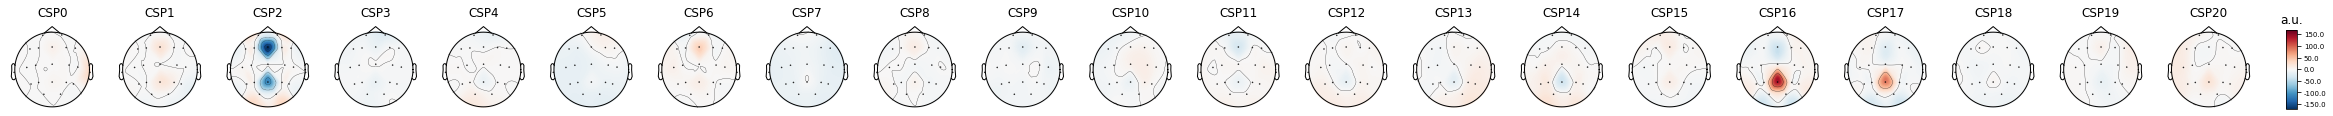

In [14]:
CSP_plot = csp.plot_patterns(info)
CSP_plot.savefig(Output_data_path+'CSP patterns.jpg')

In [15]:
Training_Data_CSP = csp.transform(np.array(Training_Data))
Testing_Data_CSP = csp.transform(np.array(Testing_Data))

In [16]:
print(Training_Data_CSP.shape)
print(Testing_Data_CSP.shape)

(761, 21, 2000)
(376, 21, 2000)


## Features

* 4 features

In [17]:
Training_Features = Feature_extration(Training_Data_CSP,features=['coherence','entropy','skew','kurtosis'])
Testing_Features = Feature_extration(Testing_Data_CSP,features=['coherence','entropy','skew','kurtosis'])

100%|████████████████████████████████████████████████████████████████████████████████| 376/376 [08:19<00:00,  1.33s/it]


In [61]:
Training_Features.shape

(761, 10626)

In [48]:
Save_features = 'D:/Record/Mne/Features/'
np.save(file=Save_features+'Training_Features.npy', arr=Training_Features)
np.save(file=Save_features+'Training_Data_label.npy', arr=np.array(Training_Data_label))

np.save(file=Save_features+'Testing_Features.npy', arr=Testing_Features)
np.save(file=Save_features+'Testing_Data_label.npy', arr=np.array(Testing_Data_label))

## ML

In [294]:
Mode = 'LR' # SVM KNN LR DT RF ET GB Ada
times = 100
num_classes = 2
cv_mode = 'GridSearchCV' #'RandomizedSearchCV'

Model_Path = 'D:/Record/Mne/Models/'+Mode+'/'
if not os.path.isdir(Model_Path):
    os.mkdir(Model_Path)

In [295]:
Model_training(num_classes,Training_Features, Training_Data_label,Testing_Features,Testing_Data_label,Mode,Model_Path,times=times,cv_mode='RandomizedSearchCV')

  0%|                                                                                          | 0/100 [00:00<?, ?it/s]

LR
Fitting 5 folds for each of 10 candidates, totalling 50 fits


  1%|▊                                                                               | 1/100 [00:36<1:00:09, 36.46s/it]

best_score:0.6410480065701376

best_params:{'pca__n_components': 550, 'LR__tol': 0.0001, 'LR__solver': 'liblinear', 'LR__penalty': 'l1', 'LR__dual': False, 'LR__C': 800}
0.6113818246589496
LR
Fitting 5 folds for each of 10 candidates, totalling 50 fits


  2%|█▌                                                                              | 2/100 [01:17<1:01:41, 37.77s/it]

best_score:0.6423990837644603

best_params:{'pca__n_components': 550, 'LR__tol': 0.0001, 'LR__solver': 'liblinear', 'LR__penalty': 'l1', 'LR__dual': False, 'LR__C': 250}
0.6078326981634334
LR
Fitting 5 folds for each of 10 candidates, totalling 50 fits


  3%|██▍                                                                             | 3/100 [02:12<1:09:25, 42.94s/it]

best_score:0.6410273298608063

best_params:{'pca__n_components': 550, 'LR__tol': 0.0001, 'LR__solver': 'liblinear', 'LR__penalty': 'l1', 'LR__dual': False, 'LR__C': 900}
0.6113818246589496
LR
Fitting 5 folds for each of 10 candidates, totalling 50 fits


  4%|███▏                                                                            | 4/100 [02:46<1:04:23, 40.25s/it]

best_score:0.6453949517120253

best_params:{'pca__n_components': 550, 'LR__tol': 0.0001, 'LR__solver': 'liblinear', 'LR__penalty': 'l1', 'LR__dual': False, 'LR__C': 200}
0.6078326981634334
LR
Fitting 5 folds for each of 10 candidates, totalling 50 fits


  5%|████                                                                              | 5/100 [03:17<59:27, 37.55s/it]

best_score:0.6404236373143902

best_params:{'pca__n_components': 550, 'LR__tol': 0.0001, 'LR__solver': 'liblinear', 'LR__penalty': 'l1', 'LR__dual': False, 'LR__C': 650}
0.6113818246589496
LR
Fitting 5 folds for each of 10 candidates, totalling 50 fits


  6%|████▊                                                                           | 6/100 [04:07<1:04:54, 41.43s/it]

best_score:0.6465731614262915

best_params:{'pca__n_components': 550, 'LR__tol': 0.0001, 'LR__solver': 'liblinear', 'LR__penalty': 'l1', 'LR__dual': False, 'LR__C': 200}
0.6078326981634334
LR
Fitting 5 folds for each of 10 candidates, totalling 50 fits


  7%|█████▌                                                                          | 7/100 [04:42<1:01:09, 39.46s/it]

best_score:0.6370421321780061

best_params:{'pca__n_components': 550, 'LR__tol': 0.0001, 'LR__solver': 'liblinear', 'LR__penalty': 'l1', 'LR__dual': False, 'LR__C': 100}
0.6164262606258099
LR
Fitting 5 folds for each of 10 candidates, totalling 50 fits


  8%|██████▍                                                                         | 8/100 [05:35<1:06:38, 43.47s/it]

best_score:0.641584959971688

best_params:{'pca__n_components': 550, 'LR__tol': 0.0001, 'LR__solver': 'liblinear', 'LR__penalty': 'l1', 'LR__dual': False, 'LR__C': 200}
0.6078326981634334
LR
Fitting 5 folds for each of 10 candidates, totalling 50 fits
best_score:0.641584959971688

best_params:{'pca__n_components': 550, 'LR__tol': 0.0001, 'LR__solver': 'liblinear', 'LR__penalty': 'l1', 'LR__dual': False, 'LR__C': 200}


  9%|███████▏                                                                        | 9/100 [06:17<1:04:59, 42.85s/it]

0.6078326981634334
LR
Fitting 5 folds for each of 10 candidates, totalling 50 fits


 10%|███████▉                                                                       | 10/100 [06:55<1:02:15, 41.51s/it]

best_score:0.6356636182172133

best_params:{'pca__n_components': 550, 'LR__tol': 0.0001, 'LR__solver': 'liblinear', 'LR__penalty': 'l1', 'LR__dual': False, 'LR__C': 500}
0.6057901962367762
LR
Fitting 5 folds for each of 10 candidates, totalling 50 fits


 11%|████████▉                                                                        | 11/100 [07:32<59:27, 40.08s/it]

best_score:0.6423990837644603

best_params:{'pca__n_components': 550, 'LR__tol': 0.0001, 'LR__solver': 'liblinear', 'LR__penalty': 'l1', 'LR__dual': False, 'LR__C': 250}
0.6078326981634334
LR
Fitting 5 folds for each of 10 candidates, totalling 50 fits


 12%|█████████▋                                                                       | 12/100 [08:03<54:43, 37.31s/it]

best_score:0.6404236373143902

best_params:{'pca__n_components': 550, 'LR__tol': 0.0001, 'LR__solver': 'liblinear', 'LR__penalty': 'l1', 'LR__dual': False, 'LR__C': 750}
0.6113818246589496
LR
Fitting 5 folds for each of 10 candidates, totalling 50 fits


 13%|██████████▌                                                                      | 13/100 [08:40<54:04, 37.29s/it]

best_score:0.6423990837644603

best_params:{'pca__n_components': 550, 'LR__tol': 0.0001, 'LR__solver': 'liblinear', 'LR__penalty': 'l1', 'LR__dual': False, 'LR__C': 250}
0.6078326981634334
LR
Fitting 5 folds for each of 10 candidates, totalling 50 fits


 14%|███████████▎                                                                     | 14/100 [09:27<57:32, 40.14s/it]

best_score:0.6423990837644603

best_params:{'pca__n_components': 550, 'LR__tol': 0.0001, 'LR__solver': 'liblinear', 'LR__penalty': 'l1', 'LR__dual': False, 'LR__C': 250}
0.6078326981634334
LR
Fitting 5 folds for each of 10 candidates, totalling 50 fits


 15%|███████████▊                                                                   | 15/100 [10:20<1:02:28, 44.10s/it]

best_score:0.6410273298608063

best_params:{'pca__n_components': 550, 'LR__tol': 0.0001, 'LR__solver': 'liblinear', 'LR__penalty': 'l1', 'LR__dual': False, 'LR__C': 900}
0.6113818246589496
LR
Fitting 5 folds for each of 10 candidates, totalling 50 fits


 16%|████████████▋                                                                  | 16/100 [11:09<1:03:52, 45.62s/it]

best_score:0.6404236373143902

best_params:{'pca__n_components': 550, 'LR__tol': 0.0001, 'LR__solver': 'liblinear', 'LR__penalty': 'l1', 'LR__dual': False, 'LR__C': 650}
0.6113818246589496
LR
Fitting 5 folds for each of 10 candidates, totalling 50 fits


 17%|█████████████▍                                                                 | 17/100 [12:03<1:06:33, 48.11s/it]

best_score:0.6393962719010791

best_params:{'pca__n_components': 550, 'LR__tol': 0.0001, 'LR__solver': 'liblinear', 'LR__penalty': 'l1', 'LR__dual': False, 'LR__C': 850}
0.6113818246589496
LR
Fitting 5 folds for each of 10 candidates, totalling 50 fits


 18%|██████████████▏                                                                | 18/100 [12:47<1:04:07, 46.92s/it]

best_score:0.6393962719010791

best_params:{'pca__n_components': 550, 'LR__tol': 0.0001, 'LR__solver': 'liblinear', 'LR__penalty': 'l1', 'LR__dual': False, 'LR__C': 900}
0.6113818246589496
LR
Fitting 5 folds for each of 10 candidates, totalling 50 fits


 19%|███████████████▍                                                                 | 19/100 [13:21<58:09, 43.08s/it]

best_score:0.638389583197099

best_params:{'pca__n_components': 550, 'LR__tol': 0.0001, 'LR__solver': 'liblinear', 'LR__penalty': 'l1', 'LR__dual': False, 'LR__C': 800}
0.6113818246589496
LR
Fitting 5 folds for each of 10 candidates, totalling 50 fits
best_score:0.6390090629884134

best_params:{'pca__n_components': 550, 'LR__tol': 0.0001, 'LR__solver': 'liblinear', 'LR__penalty': 'l1', 'LR__dual': False, 'LR__C': 300}


 20%|███████████████▊                                                               | 20/100 [14:18<1:02:59, 47.25s/it]

0.6057901962367762
LR
Fitting 5 folds for each of 10 candidates, totalling 50 fits


 21%|█████████████████                                                                | 21/100 [14:57<58:54, 44.74s/it]

best_score:0.6453949517120253

best_params:{'pca__n_components': 550, 'LR__tol': 0.0001, 'LR__solver': 'liblinear', 'LR__penalty': 'l1', 'LR__dual': False, 'LR__C': 200}
0.6078326981634334
LR
Fitting 5 folds for each of 10 candidates, totalling 50 fits


 22%|█████████████████▊                                                               | 22/100 [15:32<54:08, 41.65s/it]

best_score:0.6353530522371571

best_params:{'pca__n_components': 550, 'LR__tol': 0.0001, 'LR__solver': 'liblinear', 'LR__penalty': 'l1', 'LR__dual': False, 'LR__C': 550}
0.6093276571383328
LR
Fitting 5 folds for each of 10 candidates, totalling 50 fits


 23%|██████████████████▏                                                            | 23/100 [16:40<1:03:40, 49.62s/it]

best_score:0.6404236373143902

best_params:{'pca__n_components': 550, 'LR__tol': 0.0001, 'LR__solver': 'liblinear', 'LR__penalty': 'l1', 'LR__dual': False, 'LR__C': 700}
0.6113818246589496
LR
Fitting 5 folds for each of 10 candidates, totalling 50 fits


 24%|██████████████████▉                                                            | 24/100 [17:30<1:03:14, 49.93s/it]

best_score:0.6423990837644603

best_params:{'pca__n_components': 550, 'LR__tol': 0.0001, 'LR__solver': 'liblinear', 'LR__penalty': 'l1', 'LR__dual': False, 'LR__C': 250}
0.6078326981634334
LR
Fitting 5 folds for each of 10 candidates, totalling 50 fits
best_score:0.6453949517120253

best_params:{'pca__n_components': 550, 'LR__tol': 0.0001, 'LR__solver': 'liblinear', 'LR__penalty': 'l1', 'LR__dual': False, 'LR__C': 200}


 25%|███████████████████▊                                                           | 25/100 [18:21<1:02:44, 50.20s/it]

0.6078326981634334
LR
Fitting 5 folds for each of 10 candidates, totalling 50 fits


 26%|█████████████████████                                                            | 26/100 [19:02<58:26, 47.39s/it]

best_score:0.6336673893841074

best_params:{'pca__n_components': 550, 'LR__tol': 0.0001, 'LR__solver': 'liblinear', 'LR__penalty': 'l1', 'LR__dual': False, 'LR__C': 650}
0.6113818246589496
LR
Fitting 5 folds for each of 10 candidates, totalling 50 fits


 27%|█████████████████████▊                                                           | 27/100 [19:51<58:17, 47.91s/it]

best_score:0.6393962719010791

best_params:{'pca__n_components': 550, 'LR__tol': 0.0001, 'LR__solver': 'liblinear', 'LR__penalty': 'l1', 'LR__dual': False, 'LR__C': 850}
0.6113818246589496
LR
Fitting 5 folds for each of 10 candidates, totalling 50 fits


 28%|██████████████████████▋                                                          | 28/100 [20:34<55:29, 46.24s/it]

best_score:0.6404236373143902

best_params:{'pca__n_components': 550, 'LR__tol': 0.0001, 'LR__solver': 'liblinear', 'LR__penalty': 'l1', 'LR__dual': False, 'LR__C': 800}
0.6113818246589496
LR
Fitting 5 folds for each of 10 candidates, totalling 50 fits


 29%|███████████████████████▍                                                         | 29/100 [21:15<52:55, 44.73s/it]

best_score:0.6393962719010791

best_params:{'pca__n_components': 550, 'LR__tol': 0.0001, 'LR__solver': 'liblinear', 'LR__penalty': 'l1', 'LR__dual': False, 'LR__C': 800}
0.6113818246589496
LR
Fitting 5 folds for each of 10 candidates, totalling 50 fits


 30%|████████████████████████▎                                                        | 30/100 [21:55<50:45, 43.51s/it]

best_score:0.6393962719010791

best_params:{'pca__n_components': 550, 'LR__tol': 0.0001, 'LR__solver': 'liblinear', 'LR__penalty': 'l1', 'LR__dual': False, 'LR__C': 750}
0.6113818246589496
LR
Fitting 5 folds for each of 10 candidates, totalling 50 fits


 31%|█████████████████████████                                                        | 31/100 [22:49<53:27, 46.49s/it]

best_score:0.6404236373143902

best_params:{'pca__n_components': 550, 'LR__tol': 0.0001, 'LR__solver': 'liblinear', 'LR__penalty': 'l1', 'LR__dual': False, 'LR__C': 800}
0.6113818246589496
LR
Fitting 5 folds for each of 10 candidates, totalling 50 fits


 32%|█████████████████████████▉                                                       | 32/100 [23:37<53:18, 47.04s/it]

best_score:0.6423990837644603

best_params:{'pca__n_components': 550, 'LR__tol': 0.0001, 'LR__solver': 'liblinear', 'LR__penalty': 'l1', 'LR__dual': False, 'LR__C': 250}
0.6078326981634334
LR
Fitting 5 folds for each of 10 candidates, totalling 50 fits


 33%|██████████████████████████▋                                                      | 33/100 [24:29<54:00, 48.37s/it]

best_score:0.6423990837644603

best_params:{'pca__n_components': 550, 'LR__tol': 0.0001, 'LR__solver': 'liblinear', 'LR__penalty': 'l1', 'LR__dual': False, 'LR__C': 250}
0.6078326981634334
LR
Fitting 5 folds for each of 10 candidates, totalling 50 fits


 34%|███████████████████████████▌                                                     | 34/100 [25:00<47:41, 43.36s/it]

best_score:0.6353530522371571

best_params:{'pca__n_components': 550, 'LR__tol': 0.0001, 'LR__solver': 'liblinear', 'LR__penalty': 'l1', 'LR__dual': False, 'LR__C': 600}
0.6078326981634334
LR
Fitting 5 folds for each of 10 candidates, totalling 50 fits


 35%|████████████████████████████▎                                                    | 35/100 [25:32<43:06, 39.80s/it]

best_score:0.6410273298608063

best_params:{'pca__n_components': 550, 'LR__tol': 0.0001, 'LR__solver': 'liblinear', 'LR__penalty': 'l1', 'LR__dual': False, 'LR__C': 900}
0.6113818246589496
LR
Fitting 5 folds for each of 10 candidates, totalling 50 fits


 36%|█████████████████████████████▏                                                   | 36/100 [26:09<41:35, 38.99s/it]

best_score:0.6393962719010791

best_params:{'pca__n_components': 550, 'LR__tol': 0.0001, 'LR__solver': 'liblinear', 'LR__penalty': 'l1', 'LR__dual': False, 'LR__C': 850}
0.6113818246589496
LR
Fitting 5 folds for each of 10 candidates, totalling 50 fits


 37%|█████████████████████████████▉                                                   | 37/100 [26:55<43:08, 41.09s/it]

best_score:0.6370421321780061

best_params:{'pca__n_components': 550, 'LR__tol': 0.0001, 'LR__solver': 'liblinear', 'LR__penalty': 'l1', 'LR__dual': False, 'LR__C': 100}
0.6164262606258099
LR
Fitting 5 folds for each of 10 candidates, totalling 50 fits


 38%|██████████████████████████████▊                                                  | 38/100 [27:46<45:23, 43.93s/it]

best_score:0.6393962719010791

best_params:{'pca__n_components': 550, 'LR__tol': 0.0001, 'LR__solver': 'liblinear', 'LR__penalty': 'l1', 'LR__dual': False, 'LR__C': 800}
0.6113818246589496
LR
Fitting 5 folds for each of 10 candidates, totalling 50 fits


 39%|███████████████████████████████▌                                                 | 39/100 [28:30<44:56, 44.20s/it]

best_score:0.6390090629884134

best_params:{'pca__n_components': 550, 'LR__tol': 0.0001, 'LR__solver': 'liblinear', 'LR__penalty': 'l1', 'LR__dual': False, 'LR__C': 300}
0.6057901962367762
LR
Fitting 5 folds for each of 10 candidates, totalling 50 fits
best_score:0.6370421321780061

best_params:{'pca__n_components': 550, 'LR__tol': 0.0001, 'LR__solver': 'liblinear', 'LR__penalty': 'l1', 'LR__dual': False, 'LR__C': 100}


 40%|████████████████████████████████▍                                                | 40/100 [29:06<41:39, 41.66s/it]

0.6164262606258099
LR
Fitting 5 folds for each of 10 candidates, totalling 50 fits


 41%|█████████████████████████████████▏                                               | 41/100 [29:43<39:27, 40.14s/it]

best_score:0.6393962719010791

best_params:{'pca__n_components': 550, 'LR__tol': 0.0001, 'LR__solver': 'liblinear', 'LR__penalty': 'l1', 'LR__dual': False, 'LR__C': 750}
0.6113818246589496
LR
Fitting 5 folds for each of 10 candidates, totalling 50 fits


 42%|██████████████████████████████████                                               | 42/100 [30:20<38:00, 39.32s/it]

best_score:0.6393962719010791

best_params:{'pca__n_components': 550, 'LR__tol': 0.0001, 'LR__solver': 'liblinear', 'LR__penalty': 'l1', 'LR__dual': False, 'LR__C': 850}
0.6113818246589496
LR
Fitting 5 folds for each of 10 candidates, totalling 50 fits


 43%|██████████████████████████████████▊                                              | 43/100 [30:54<35:48, 37.70s/it]

best_score:0.6410273298608063

best_params:{'pca__n_components': 550, 'LR__tol': 0.0001, 'LR__solver': 'liblinear', 'LR__penalty': 'l1', 'LR__dual': False, 'LR__C': 850}
0.6113818246589496
LR
Fitting 5 folds for each of 10 candidates, totalling 50 fits


 44%|███████████████████████████████████▋                                             | 44/100 [31:44<38:44, 41.51s/it]

best_score:0.6390090629884134

best_params:{'pca__n_components': 550, 'LR__tol': 0.0001, 'LR__solver': 'liblinear', 'LR__penalty': 'l1', 'LR__dual': False, 'LR__C': 300}
0.6057901962367762
LR
Fitting 5 folds for each of 10 candidates, totalling 50 fits


 45%|████████████████████████████████████▍                                            | 45/100 [32:12<34:07, 37.22s/it]

best_score:0.6393962719010791

best_params:{'pca__n_components': 550, 'LR__tol': 0.0001, 'LR__solver': 'liblinear', 'LR__penalty': 'l1', 'LR__dual': False, 'LR__C': 700}
0.6113818246589496
LR
Fitting 5 folds for each of 10 candidates, totalling 50 fits


 46%|█████████████████████████████████████▎                                           | 46/100 [32:37<30:18, 33.67s/it]

best_score:0.6353530522371571

best_params:{'pca__n_components': 550, 'LR__tol': 0.0001, 'LR__solver': 'liblinear', 'LR__penalty': 'l1', 'LR__dual': False, 'LR__C': 550}
0.6093276571383328
LR
Fitting 5 folds for each of 10 candidates, totalling 50 fits


 47%|██████████████████████████████████████                                           | 47/100 [33:09<29:16, 33.13s/it]

best_score:0.6103320417588933

best_params:{'pca__n_components': 100, 'LR__tol': 0.0001, 'LR__solver': 'liblinear', 'LR__penalty': 'l1', 'LR__dual': False, 'LR__C': 150}
0.602553161256802
LR
Fitting 5 folds for each of 10 candidates, totalling 50 fits


 48%|██████████████████████████████████████▉                                          | 48/100 [33:56<32:24, 37.40s/it]

best_score:0.6410273298608063

best_params:{'pca__n_components': 550, 'LR__tol': 0.0001, 'LR__solver': 'liblinear', 'LR__penalty': 'l1', 'LR__dual': False, 'LR__C': 850}
0.6113818246589496
LR
Fitting 5 folds for each of 10 candidates, totalling 50 fits


 49%|███████████████████████████████████████▋                                         | 49/100 [34:38<33:00, 38.82s/it]

best_score:0.6423990837644603

best_params:{'pca__n_components': 550, 'LR__tol': 0.0001, 'LR__solver': 'liblinear', 'LR__penalty': 'l1', 'LR__dual': False, 'LR__C': 250}
0.6078326981634334
LR
Fitting 5 folds for each of 10 candidates, totalling 50 fits


 50%|████████████████████████████████████████▌                                        | 50/100 [35:18<32:35, 39.10s/it]

best_score:0.6373492810702629

best_params:{'pca__n_components': 550, 'LR__tol': 0.0001, 'LR__solver': 'liblinear', 'LR__penalty': 'l1', 'LR__dual': False, 'LR__C': 500}
0.6057901962367762
LR
Fitting 5 folds for each of 10 candidates, totalling 50 fits


 51%|█████████████████████████████████████████▎                                       | 51/100 [36:04<33:32, 41.06s/it]

best_score:0.638389583197099

best_params:{'pca__n_components': 550, 'LR__tol': 0.0001, 'LR__solver': 'liblinear', 'LR__penalty': 'l1', 'LR__dual': False, 'LR__C': 900}
0.6149086906077852
LR
Fitting 5 folds for each of 10 candidates, totalling 50 fits


 52%|██████████████████████████████████████████                                       | 52/100 [36:47<33:21, 41.69s/it]

best_score:0.6423990837644603

best_params:{'pca__n_components': 550, 'LR__tol': 0.0001, 'LR__solver': 'liblinear', 'LR__penalty': 'l1', 'LR__dual': False, 'LR__C': 250}
0.6078326981634334
LR
Fitting 5 folds for each of 10 candidates, totalling 50 fits


 53%|██████████████████████████████████████████▉                                      | 53/100 [37:26<32:01, 40.88s/it]

best_score:0.641584959971688

best_params:{'pca__n_components': 550, 'LR__tol': 0.0001, 'LR__solver': 'liblinear', 'LR__penalty': 'l1', 'LR__dual': False, 'LR__C': 200}
0.6078326981634334
LR
Fitting 5 folds for each of 10 candidates, totalling 50 fits


 54%|███████████████████████████████████████████▋                                     | 54/100 [38:12<32:34, 42.49s/it]

best_score:0.637284755937763

best_params:{'pca__n_components': 550, 'LR__tol': 0.0001, 'LR__solver': 'liblinear', 'LR__penalty': 'l1', 'LR__dual': False, 'LR__C': 300}
0.6057901962367762
LR
Fitting 5 folds for each of 10 candidates, totalling 50 fits


 55%|████████████████████████████████████████████▌                                    | 55/100 [38:54<31:38, 42.19s/it]

best_score:0.6465731614262915

best_params:{'pca__n_components': 550, 'LR__tol': 0.0001, 'LR__solver': 'liblinear', 'LR__penalty': 'l1', 'LR__dual': False, 'LR__C': 200}
0.6078326981634334
LR
Fitting 5 folds for each of 10 candidates, totalling 50 fits


 56%|█████████████████████████████████████████████▎                                   | 56/100 [39:38<31:27, 42.89s/it]

best_score:0.6396337014049468

best_params:{'pca__n_components': 550, 'LR__tol': 0.0001, 'LR__solver': 'liblinear', 'LR__penalty': 'l1', 'LR__dual': False, 'LR__C': 300}
0.6057901962367762
LR
Fitting 5 folds for each of 10 candidates, totalling 50 fits


 57%|██████████████████████████████████████████████▏                                  | 57/100 [40:25<31:35, 44.09s/it]

best_score:0.6393962719010791

best_params:{'pca__n_components': 550, 'LR__tol': 0.0001, 'LR__solver': 'liblinear', 'LR__penalty': 'l1', 'LR__dual': False, 'LR__C': 950}
0.6149086906077852
LR
Fitting 5 folds for each of 10 candidates, totalling 50 fits


 58%|██████████████████████████████████████████████▉                                  | 58/100 [40:50<26:55, 38.46s/it]

best_score:0.6157873854421485

best_params:{'pca__n_components': 150, 'LR__tol': 0.0001, 'LR__solver': 'liblinear', 'LR__penalty': 'l1', 'LR__dual': False, 'LR__C': 600}
0.6037445766178942
LR
Fitting 5 folds for each of 10 candidates, totalling 50 fits
best_score:0.6055991066710844

best_params:{'pca__n_components': 100, 'LR__tol': 0.0001, 'LR__solver': 'liblinear', 'LR__penalty': 'l1', 'LR__dual': False, 'LR__C': 700}


 59%|███████████████████████████████████████████████▊                                 | 59/100 [41:08<21:56, 32.12s/it]

0.6081305834768892
LR
Fitting 5 folds for each of 10 candidates, totalling 50 fits


 60%|████████████████████████████████████████████████▌                                | 60/100 [41:56<24:43, 37.08s/it]

best_score:0.6465731614262915

best_params:{'pca__n_components': 550, 'LR__tol': 0.0001, 'LR__solver': 'liblinear', 'LR__penalty': 'l1', 'LR__dual': False, 'LR__C': 200}
0.6078326981634334
LR
Fitting 5 folds for each of 10 candidates, totalling 50 fits


 61%|█████████████████████████████████████████████████▍                               | 61/100 [42:36<24:30, 37.69s/it]

best_score:0.6393962719010791

best_params:{'pca__n_components': 550, 'LR__tol': 0.0001, 'LR__solver': 'liblinear', 'LR__penalty': 'l1', 'LR__dual': False, 'LR__C': 900}
0.6113818246589496
LR
Fitting 5 folds for each of 10 candidates, totalling 50 fits


 62%|██████████████████████████████████████████████████▏                              | 62/100 [43:08<22:58, 36.28s/it]

best_score:0.6363515203181718

best_params:{'pca__n_components': 550, 'LR__tol': 0.0001, 'LR__solver': 'liblinear', 'LR__penalty': 'l1', 'LR__dual': False, 'LR__C': 500}
0.6057901962367762
LR
Fitting 5 folds for each of 10 candidates, totalling 50 fits


 63%|███████████████████████████████████████████████████                              | 63/100 [43:50<23:19, 37.84s/it]

best_score:0.6404236373143902

best_params:{'pca__n_components': 550, 'LR__tol': 0.0001, 'LR__solver': 'liblinear', 'LR__penalty': 'l1', 'LR__dual': False, 'LR__C': 800}
0.6113818246589496
LR
Fitting 5 folds for each of 10 candidates, totalling 50 fits


 64%|███████████████████████████████████████████████████▊                             | 64/100 [44:22<21:42, 36.19s/it]

best_score:0.6349431110204702

best_params:{'pca__n_components': 550, 'LR__tol': 0.0001, 'LR__solver': 'liblinear', 'LR__penalty': 'l1', 'LR__dual': False, 'LR__C': 350}
0.6093276571383328
LR
Fitting 5 folds for each of 10 candidates, totalling 50 fits


 65%|████████████████████████████████████████████████████▋                            | 65/100 [44:55<20:33, 35.23s/it]

best_score:0.6349431110204702

best_params:{'pca__n_components': 550, 'LR__tol': 0.0001, 'LR__solver': 'liblinear', 'LR__penalty': 'l1', 'LR__dual': False, 'LR__C': 350}
0.6057901962367762
LR
Fitting 5 folds for each of 10 candidates, totalling 50 fits


 66%|█████████████████████████████████████████████████████▍                           | 66/100 [45:22<18:35, 32.81s/it]

best_score:0.637284755937763

best_params:{'pca__n_components': 550, 'LR__tol': 0.0001, 'LR__solver': 'liblinear', 'LR__penalty': 'l1', 'LR__dual': False, 'LR__C': 300}
0.6057901962367762
LR
Fitting 5 folds for each of 10 candidates, totalling 50 fits
best_score:0.6363515203181718

best_params:{'pca__n_components': 550, 'LR__tol': 0.0001, 'LR__solver': 'liblinear', 'LR__penalty': 'l1', 'LR__dual': False, 'LR__C': 550}


 67%|██████████████████████████████████████████████████████▎                          | 67/100 [46:12<20:45, 37.73s/it]

0.6057901962367762
LR
Fitting 5 folds for each of 10 candidates, totalling 50 fits


 68%|███████████████████████████████████████████████████████                          | 68/100 [47:07<22:54, 42.94s/it]

best_score:0.6373492810702629

best_params:{'pca__n_components': 550, 'LR__tol': 0.0001, 'LR__solver': 'liblinear', 'LR__penalty': 'l1', 'LR__dual': False, 'LR__C': 500}
0.6057901962367762
LR
Fitting 5 folds for each of 10 candidates, totalling 50 fits


 69%|███████████████████████████████████████████████████████▉                         | 69/100 [47:40<20:38, 39.95s/it]

best_score:0.6453949517120253

best_params:{'pca__n_components': 550, 'LR__tol': 0.0001, 'LR__solver': 'liblinear', 'LR__penalty': 'l1', 'LR__dual': False, 'LR__C': 200}
0.6078326981634334
LR
Fitting 5 folds for each of 10 candidates, totalling 50 fits


 70%|████████████████████████████████████████████████████████▋                        | 70/100 [48:10<18:34, 37.16s/it]

best_score:0.6427631696859541

best_params:{'pca__n_components': 550, 'LR__tol': 0.0001, 'LR__solver': 'liblinear', 'LR__penalty': 'l1', 'LR__dual': False, 'LR__C': 200}
0.6078326981634334
LR
Fitting 5 folds for each of 10 candidates, totalling 50 fits


 71%|█████████████████████████████████████████████████████████▌                       | 71/100 [48:49<18:10, 37.61s/it]

best_score:0.6370421321780061

best_params:{'pca__n_components': 550, 'LR__tol': 0.0001, 'LR__solver': 'liblinear', 'LR__penalty': 'l1', 'LR__dual': False, 'LR__C': 100}
0.6164262606258099
LR
Fitting 5 folds for each of 10 candidates, totalling 50 fits
best_score:0.6423990837644603

best_params:{'pca__n_components': 550, 'LR__tol': 0.0001, 'LR__solver': 'liblinear', 'LR__penalty': 'l1', 'LR__dual': False, 'LR__C': 250}


 72%|██████████████████████████████████████████████████████████▎                      | 72/100 [49:30<17:57, 38.47s/it]

0.6078326981634334
LR
Fitting 5 folds for each of 10 candidates, totalling 50 fits


 73%|███████████████████████████████████████████████████████████▏                     | 73/100 [50:17<18:30, 41.14s/it]

best_score:0.6404236373143902

best_params:{'pca__n_components': 550, 'LR__tol': 0.0001, 'LR__solver': 'liblinear', 'LR__penalty': 'l1', 'LR__dual': False, 'LR__C': 750}
0.6113818246589496
LR
Fitting 5 folds for each of 10 candidates, totalling 50 fits


 74%|███████████████████████████████████████████████████████████▉                     | 74/100 [51:03<18:25, 42.54s/it]

best_score:0.6393962719010791

best_params:{'pca__n_components': 550, 'LR__tol': 0.0001, 'LR__solver': 'liblinear', 'LR__penalty': 'l1', 'LR__dual': False, 'LR__C': 850}
0.6113818246589496
LR
Fitting 5 folds for each of 10 candidates, totalling 50 fits


 75%|████████████████████████████████████████████████████████████▊                    | 75/100 [51:57<19:11, 46.08s/it]

best_score:0.6423990837644603

best_params:{'pca__n_components': 550, 'LR__tol': 0.0001, 'LR__solver': 'liblinear', 'LR__penalty': 'l1', 'LR__dual': False, 'LR__C': 250}
0.6078326981634334
LR
Fitting 5 folds for each of 10 candidates, totalling 50 fits


 76%|█████████████████████████████████████████████████████████████▌                   | 76/100 [52:48<19:00, 47.53s/it]

best_score:0.6393962719010791

best_params:{'pca__n_components': 550, 'LR__tol': 0.0001, 'LR__solver': 'liblinear', 'LR__penalty': 'l1', 'LR__dual': False, 'LR__C': 950}
0.6149086906077852
LR
Fitting 5 folds for each of 10 candidates, totalling 50 fits


 77%|██████████████████████████████████████████████████████████████▎                  | 77/100 [53:31<17:43, 46.24s/it]

best_score:0.6410273298608063

best_params:{'pca__n_components': 550, 'LR__tol': 0.0001, 'LR__solver': 'liblinear', 'LR__penalty': 'l1', 'LR__dual': False, 'LR__C': 750}
0.6113818246589496
LR
Fitting 5 folds for each of 10 candidates, totalling 50 fits


 78%|███████████████████████████████████████████████████████████████▏                 | 78/100 [54:05<15:37, 42.62s/it]

best_score:0.6326400239707961

best_params:{'pca__n_components': 550, 'LR__tol': 0.0001, 'LR__solver': 'liblinear', 'LR__penalty': 'l1', 'LR__dual': False, 'LR__C': 700}
0.6113818246589496
LR
Fitting 5 folds for each of 10 candidates, totalling 50 fits
best_score:0.6393962719010791

best_params:{'pca__n_components': 550, 'LR__tol': 0.0001, 'LR__solver': 'liblinear', 'LR__penalty': 'l1', 'LR__dual': False, 'LR__C': 950}


 79%|███████████████████████████████████████████████████████████████▉                 | 79/100 [54:53<15:23, 43.97s/it]

0.6113818246589496
LR
Fitting 5 folds for each of 10 candidates, totalling 50 fits
best_score:0.6373492810702629

best_params:{'pca__n_components': 550, 'LR__tol': 0.0001, 'LR__solver': 'liblinear', 'LR__penalty': 'l1', 'LR__dual': False, 'LR__C': 450}


 80%|████████████████████████████████████████████████████████████████▊                | 80/100 [55:44<15:24, 46.22s/it]

0.6057901962367762
LR
Fitting 5 folds for each of 10 candidates, totalling 50 fits


 81%|█████████████████████████████████████████████████████████████████▌               | 81/100 [56:29<14:33, 45.98s/it]

best_score:0.6390090629884134

best_params:{'pca__n_components': 550, 'LR__tol': 0.0001, 'LR__solver': 'liblinear', 'LR__penalty': 'l1', 'LR__dual': False, 'LR__C': 300}
0.6057901962367762
LR
Fitting 5 folds for each of 10 candidates, totalling 50 fits


 82%|██████████████████████████████████████████████████████████████████▍              | 82/100 [57:22<14:22, 47.92s/it]

best_score:0.6427631696859541

best_params:{'pca__n_components': 550, 'LR__tol': 0.0001, 'LR__solver': 'liblinear', 'LR__penalty': 'l1', 'LR__dual': False, 'LR__C': 200}
0.6078326981634334
LR
Fitting 5 folds for each of 10 candidates, totalling 50 fits


 83%|███████████████████████████████████████████████████████████████████▏             | 83/100 [57:56<12:23, 43.74s/it]

best_score:0.6110840275133614

best_params:{'pca__n_components': 100, 'LR__tol': 0.0001, 'LR__solver': 'liblinear', 'LR__penalty': 'l1', 'LR__dual': False, 'LR__C': 650}
0.6067442550610945
LR
Fitting 5 folds for each of 10 candidates, totalling 50 fits


 84%|████████████████████████████████████████████████████████████████████             | 84/100 [58:41<11:45, 44.07s/it]

best_score:0.6370421321780061

best_params:{'pca__n_components': 550, 'LR__tol': 0.0001, 'LR__solver': 'liblinear', 'LR__penalty': 'l1', 'LR__dual': False, 'LR__C': 100}
0.6164262606258099
LR
Fitting 5 folds for each of 10 candidates, totalling 50 fits


 85%|████████████████████████████████████████████████████████████████████▊            | 85/100 [59:20<10:37, 42.50s/it]

best_score:0.6410273298608063

best_params:{'pca__n_components': 550, 'LR__tol': 0.0001, 'LR__solver': 'liblinear', 'LR__penalty': 'l1', 'LR__dual': False, 'LR__C': 950}
0.6149086906077852
LR
Fitting 5 folds for each of 10 candidates, totalling 50 fits


 86%|███████████████████████████████████████████████████████████████████▉           | 86/100 [1:00:07<10:16, 44.01s/it]

best_score:0.6404236373143902

best_params:{'pca__n_components': 550, 'LR__tol': 0.0001, 'LR__solver': 'liblinear', 'LR__penalty': 'l1', 'LR__dual': False, 'LR__C': 750}
0.6113818246589496
LR
Fitting 5 folds for each of 10 candidates, totalling 50 fits


 87%|████████████████████████████████████████████████████████████████████▋          | 87/100 [1:00:39<08:43, 40.31s/it]

best_score:0.6393962719010791

best_params:{'pca__n_components': 550, 'LR__tol': 0.0001, 'LR__solver': 'liblinear', 'LR__penalty': 'l1', 'LR__dual': False, 'LR__C': 850}
0.6113818246589496
LR
Fitting 5 folds for each of 10 candidates, totalling 50 fits


 88%|█████████████████████████████████████████████████████████████████████▌         | 88/100 [1:01:47<09:43, 48.64s/it]

best_score:0.6400206411568263

best_params:{'pca__n_components': 550, 'LR__tol': 0.0001, 'LR__solver': 'liblinear', 'LR__penalty': 'l1', 'LR__dual': False, 'LR__C': 950}
0.6113818246589496
LR
Fitting 5 folds for each of 10 candidates, totalling 50 fits


 89%|██████████████████████████████████████████████████████████████████████▎        | 89/100 [1:02:35<08:52, 48.43s/it]

best_score:0.641584959971688

best_params:{'pca__n_components': 550, 'LR__tol': 0.0001, 'LR__solver': 'liblinear', 'LR__penalty': 'l1', 'LR__dual': False, 'LR__C': 200}
0.6078326981634334
LR
Fitting 5 folds for each of 10 candidates, totalling 50 fits


 90%|███████████████████████████████████████████████████████████████████████        | 90/100 [1:03:28<08:18, 49.88s/it]

best_score:0.6423990837644603

best_params:{'pca__n_components': 550, 'LR__tol': 0.0001, 'LR__solver': 'liblinear', 'LR__penalty': 'l1', 'LR__dual': False, 'LR__C': 250}
0.6078326981634334
LR
Fitting 5 folds for each of 10 candidates, totalling 50 fits


 91%|███████████████████████████████████████████████████████████████████████▉       | 91/100 [1:03:59<06:37, 44.17s/it]

best_score:0.6336673893841074

best_params:{'pca__n_components': 550, 'LR__tol': 0.0001, 'LR__solver': 'liblinear', 'LR__penalty': 'l1', 'LR__dual': False, 'LR__C': 650}
0.6113818246589496
LR
Fitting 5 folds for each of 10 candidates, totalling 50 fits


 92%|████████████████████████████████████████████████████████████████████████▋      | 92/100 [1:04:33<05:28, 41.03s/it]

best_score:0.6393962719010791

best_params:{'pca__n_components': 550, 'LR__tol': 0.0001, 'LR__solver': 'liblinear', 'LR__penalty': 'l1', 'LR__dual': False, 'LR__C': 950}
0.6149086906077852
LR
Fitting 5 folds for each of 10 candidates, totalling 50 fits


 93%|█████████████████████████████████████████████████████████████████████████▍     | 93/100 [1:05:14<04:47, 41.00s/it]

best_score:0.6393962719010791

best_params:{'pca__n_components': 550, 'LR__tol': 0.0001, 'LR__solver': 'liblinear', 'LR__penalty': 'l1', 'LR__dual': False, 'LR__C': 800}
0.6113818246589496
LR
Fitting 5 folds for each of 10 candidates, totalling 50 fits


 94%|██████████████████████████████████████████████████████████████████████████▎    | 94/100 [1:05:59<04:13, 42.21s/it]

best_score:0.6465731614262915

best_params:{'pca__n_components': 550, 'LR__tol': 0.0001, 'LR__solver': 'liblinear', 'LR__penalty': 'l1', 'LR__dual': False, 'LR__C': 200}
0.6078326981634334
LR
Fitting 5 folds for each of 10 candidates, totalling 50 fits


 95%|███████████████████████████████████████████████████████████████████████████    | 95/100 [1:06:42<03:32, 42.45s/it]

best_score:0.6453949517120253

best_params:{'pca__n_components': 550, 'LR__tol': 0.0001, 'LR__solver': 'liblinear', 'LR__penalty': 'l1', 'LR__dual': False, 'LR__C': 200}
0.6078326981634334
LR
Fitting 5 folds for each of 10 candidates, totalling 50 fits


 96%|███████████████████████████████████████████████████████████████████████████▊   | 96/100 [1:07:18<02:42, 40.51s/it]

best_score:0.6373492810702629

best_params:{'pca__n_components': 550, 'LR__tol': 0.0001, 'LR__solver': 'liblinear', 'LR__penalty': 'l1', 'LR__dual': False, 'LR__C': 500}
0.6057901962367762
LR
Fitting 5 folds for each of 10 candidates, totalling 50 fits


 97%|████████████████████████████████████████████████████████████████████████████▋  | 97/100 [1:08:00<02:03, 41.03s/it]

best_score:0.6373492810702629

best_params:{'pca__n_components': 550, 'LR__tol': 0.0001, 'LR__solver': 'liblinear', 'LR__penalty': 'l1', 'LR__dual': False, 'LR__C': 450}
0.6057901962367762
LR
Fitting 5 folds for each of 10 candidates, totalling 50 fits


 98%|█████████████████████████████████████████████████████████████████████████████▍ | 98/100 [1:08:39<01:21, 40.57s/it]

best_score:0.6370421321780061

best_params:{'pca__n_components': 550, 'LR__tol': 0.0001, 'LR__solver': 'liblinear', 'LR__penalty': 'l1', 'LR__dual': False, 'LR__C': 100}
0.6164262606258099
LR
Fitting 5 folds for each of 10 candidates, totalling 50 fits
best_score:0.6404236373143902

best_params:{'pca__n_components': 550, 'LR__tol': 0.0001, 'LR__solver': 'liblinear', 'LR__penalty': 'l1', 'LR__dual': False, 'LR__C': 650}


 99%|██████████████████████████████████████████████████████████████████████████████▏| 99/100 [1:09:12<00:38, 38.25s/it]

0.6113818246589496
LR
Fitting 5 folds for each of 10 candidates, totalling 50 fits


100%|██████████████████████████████████████████████████████████████████████████████| 100/100 [1:09:46<00:00, 41.86s/it]

best_score:0.6393962719010791

best_params:{'pca__n_components': 550, 'LR__tol': 0.0001, 'LR__solver': 'liblinear', 'LR__penalty': 'l1', 'LR__dual': False, 'LR__C': 900}
0.6113818246589496


## T-test p-value

In [301]:
LR_f1 = pd.read_csv('D:/Record/Mne/Models/LR/LR_f1.csv',index_col='Unnamed: 0')

In [302]:
SVM_f1 = pd.read_csv('D:/Record/Mne/Models/SVM/SVM_f1.csv',index_col='Unnamed: 0')

In [310]:
compare_results = scipy.stats.ttest_ind(LR_f1['0'].values,SVM_f1['0'].values)

In [313]:
compare_results[1]

2.939024739854814e-55

In [315]:
print(compare_results[1]*100)

2.939024739854814e-53


In [316]:
0.6356 + 0.6019+0.6195+0.6026+0.6166+0.6073+0.6268

4.3103

In [318]:
4.3103 / 7

0.6157571428571428

In [319]:
0.6451 - 0.6158

0.029299999999999993

In [320]:
0.6532 - 0.6158

0.03739999999999999